In [3]:
import h5py
import os
import pickle
from tqdm import tqdm
from time import gmtime, strftime
import numpy as np
import math
from sklearn import metrics
import tensorflow as tf
from tensorflow.keras import layers,Model
from sklearn.model_selection import KFold
import gc
import time
from sklearn.model_selection import KFold
import csv
import pandas as pd
import tensorflow as tf
from sklearn.metrics import roc_curve, auc, confusion_matrix, matthews_corrcoef, classification_report
import matplotlib.pyplot as plt

In [6]:

MAXSEQ = 1274
NUM_FEATURE = 20
NUM_FILTER = 128
NUM_HIDDEN = 512
BATCH_SIZE = 128
WINDOW_SIZES = [4,6,8]
NUM_CLASSES = 2
CLASS_NAMES = ['1', '0']
EPOCHS = 50
K_FOLD = 5
VALIDATION_MODE = "cross"

def load_ds(file_path):
    NUM_SAMPLES = 0
    with open(file_path) as file:
        NUM_SAMPLES = sum(1 for row in file)

    data = np.zeros((NUM_SAMPLES, MAXSEQ * NUM_FEATURE), dtype=np.float32)
    labels = np.zeros((NUM_SAMPLES, 1), dtype=np.uint8)

    with open(file_path) as file:
        file = csv.reader(file, delimiter=',')
        m = 0
        for row in file:
            labels[m] = int(row[0])
            data[m] = np.array(row[1:]).astype('float32')
            m += 1
            print(f"\rReading {file_path}...\t{m}/{NUM_SAMPLES}", end='')
    print('\tDone')
    return data, labels

x_train, y_train = load_ds('/content/drive/MyDrive/s1116049/train_data_A.csv')
x_test, y_test = load_ds('/content/drive/MyDrive/s1116049/test_data_A.csv')

# Add a channels dimension
x_train = np.reshape(x_train, [-1, 1, MAXSEQ, NUM_FEATURE])
x_test = np.reshape(x_test, [-1, 1, MAXSEQ, NUM_FEATURE])

print(f"Train shape: {x_train.shape}")
print(f"Test shape: {x_test.shape}")

print(f"Train label shape: {y_train.shape}")
print(f"Test label shape: {y_test.shape}")


Reading /content/drive/MyDrive/s1116049/train_data_A.csv...	1398/1398	Done
Reading /content/drive/MyDrive/s1116049/test_data_A.csv...	278/278	Done
Train shape: (1398, 1, 1274, 20)
Test shape: (278, 1, 1274, 20)
Train label shape: (1398, 1)
Test label shape: (278, 1)


In [7]:
import numpy as np
from tensorflow.keras import layers, Model
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, matthews_corrcoef
from sklearn.model_selection import KFold

def build_model(input_shape, window_sizes, num_filters, num_hidden):
    inputs = layers.Input(shape=input_shape)
    conv_layers = []
    for window_size in window_sizes:
        conv = layers.Conv2D(filters=num_filters, kernel_size=(1, window_size), activation='relu', padding='valid')(inputs)
        pool = layers.MaxPooling2D(pool_size=(1, input_shape[1] - window_size + 1), strides=(1, input_shape[1]), padding='valid')(conv)
        flat = layers.Flatten()(pool)
        conv_layers.append(flat)
    x = layers.Concatenate()(conv_layers)
    x = layers.Dropout(rate=0.6)(x)
    x = layers.Dense(num_hidden, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    return model

# Cross-validation on training data
metrics_summary = {'TP': [], 'FP': [], 'TN': [], 'FN': [], 'Sens': [], 'Spec': [], 'Acc': [], 'MCC': [], 'AUC': [], 'F1': []}
roc_values = {'fpr': [], 'tpr': [], 'auc': []}

kfold = KFold(n_splits=K_FOLD, shuffle=True, random_state=42)  # Enable shuffling

for fold, (train_index, val_index) in enumerate(kfold.split(x_train)):
    X_train_fold, X_val_fold = x_train[train_index], x_train[val_index]
    Y_train_fold, Y_val_fold = y_train[train_index], y_train[val_index]

    model = build_model(input_shape=(1, MAXSEQ, NUM_FEATURE), window_sizes=WINDOW_SIZES, num_filters=NUM_FILTER, num_hidden=NUM_HIDDEN)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    model.fit(X_train_fold, Y_train_fold, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, shuffle=True)  # Enable shuffling

    Y_val_pred = model.predict(X_val_fold).flatten()

    fpr, tpr, _ = roc_curve(Y_val_fold, Y_val_pred)
    roc_auc = auc(fpr, tpr)

    roc_values['fpr'].append(fpr.tolist())
    roc_values['tpr'].append(tpr.tolist())
    roc_values['auc'].append(roc_auc)
    metrics_summary['AUC'].append(roc_auc)

    Y_val_pred_binary = (Y_val_pred > 0.5).astype(int)
    cm = confusion_matrix(Y_val_fold, Y_val_pred_binary)
    TP = cm[1, 1]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TN = cm[0, 0]

    metrics_summary['TP'].append(TP)
    metrics_summary['FP'].append(FP)
    metrics_summary['TN'].append(TN)
    metrics_summary['FN'].append(FN)
    metrics_summary['Sens'].append(TP / (TP + FN) if (TP + FN) else 0)
    metrics_summary['Spec'].append(TN / (TN + FP) if (TN + FP) else 0)
    metrics_summary['Acc'].append((TP + TN) / cm.sum())
    metrics_summary['MCC'].append(matthews_corrcoef(Y_val_fold, Y_val_pred_binary) if (TP + FP) * (TP + FN) * (TN + FP) * (TN + FN) else 0)
    metrics_summary['F1'].append(2 * TP / (2 * TP + FP + FN) if (2 * TP + FP + FN) else 0)

    print(f"\nFold {fold + 1} Classification Report:")
    print(classification_report(Y_val_fold, Y_val_pred_binary))

# Calculate mean ROC values
mean_fpr = np.linspace(0, 1, 100)
tpr_interp_list = [np.interp(mean_fpr, fpr, tpr) for fpr, tpr in zip(roc_values['fpr'], roc_values['tpr'])]
mean_tpr = np.mean(tpr_interp_list, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)

print(f"Mean AUC: {mean_auc:.4f}")

print("Aggregated Metrics:")
print(f"  TP={np.mean(metrics_summary['TP']):.0f}, FP={np.mean(metrics_summary['FP']):.0f}, TN={np.mean(metrics_summary['TN']):.0f}, FN={np.mean(metrics_summary['FN']):.0f}")
print(f"  Sens={np.mean(metrics_summary['Sens']):.4f}, Spec={np.mean(metrics_summary['Spec']):.4f}, Acc={np.mean(metrics_summary['Acc']):.4f}, MCC={np.mean(metrics_summary['MCC']):.4f}, AUC={np.mean(metrics_summary['AUC']):.4f}, F1={np.mean(metrics_summary['F1']):.4f}")

# Final model training on entire training data
final_model = build_model(input_shape=(1, MAXSEQ, NUM_FEATURE), window_sizes=WINDOW_SIZES, num_filters=NUM_FILTER, num_hidden=NUM_HIDDEN)
final_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

final_model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, shuffle=True)  # Enable shuffling

# Evaluate the final model on the test data
y_test_pred = final_model.predict(x_test).flatten()
y_test_pred_binary = (y_test_pred > 0.5).astype(int)
cm_test = confusion_matrix(y_test, y_test_pred_binary)
tp_test = cm_test[1, 1]
fp_test = cm_test[0, 1]
fn_test = cm_test[1, 0]
tn_test = cm_test[0, 0]

test_sens = tp_test / (tp_test + fn_test) if (tp_test + fn_test) else 0
test_spec = tn_test / (tn_test + fp_test) if (tn_test + fp_test) else 0
test_acc = (tp_test + tn_test) / cm_test.sum()
test_mcc = matthews_corrcoef(y_test, y_test_pred_binary) if (tp_test + fp_test) * (tp_test + fn_test) * (tn_test + fp_test) * (tn_test + fn_test) else 0
test_f1 = 2 * tp_test / (2 * tp_test + fp_test + fn_test) if (2 * tp_test + fp_test + fn_test) else 0

print("\nFinal Model Test Metrics:")
print(f"  TP={tp_test}, FP={fp_test}, TN={tn_test}, FN={fn_test}")
print(f"  Sens={test_sens:.4f}, Spec={test_spec:.4f}, Acc={test_acc:.4f}, MCC={test_mcc:.4f}, F1={test_f1:.4f}")
print(classification_report(y_test, y_test_pred_binary))


Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 378ms/step - accuracy: 0.5148 - loss: 3.8262
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.5399 - loss: 2.1262
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.5601 - loss: 1.1395
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.5194 - loss: 0.9822
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.5132 - loss: 0.8791
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.5692 - loss: 0.7579
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.5914 - loss: 0.7128
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.6202 - loss: 0.6694
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.6240 - loss: 0.6532
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.6244 - loss: 0.6744
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.6452 - loss: 0.6439
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.6646 - lo

Reading /content/drive/MyDrive/s1116049/train_data_A.csv...	1398/1398	Done
Reading /content/drive/MyDrive/s1116049/test_data_A.csv...	278/278	Done
Train shape: (1398, 1, 1274, 20)
Test shape: (278, 1, 1274, 20)
Train label shape: (1398, 1)
Test label shape: (278, 1)
Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 263ms/step - accuracy: 0.5115 - loss: 4.3477
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.5047 - loss: 1.5991
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.5409 - loss: 1.0490
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.5717 - loss: 0.8287
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.5760 - loss: 0.7709
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.5919 - loss: 0.7522
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.6188 - loss: 0.6943
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.6370 - loss: 0.6695
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 110m

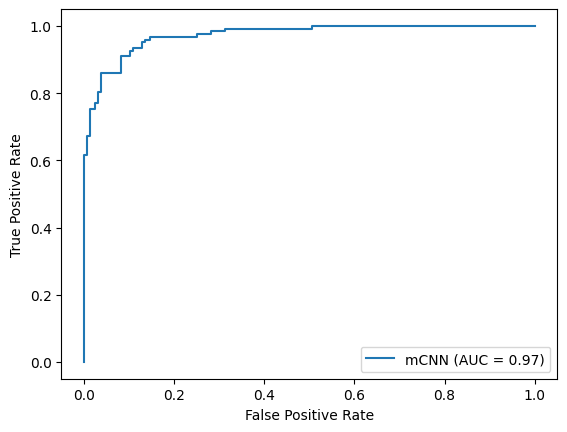

In [17]:
import numpy as np
import csv
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
from sklearn.metrics import roc_curve
import math

# Define constants
MAXSEQ = 1274
NUM_FEATURE = 20
NUM_FILTER = 128
NUM_HIDDEN = 512
BATCH_SIZE = 128
WINDOW_SIZES = [2,4,6]
CLASS_NAMES = ['1', '0']
EPOCHS = 50
VALIDATION_MODE = "independent"
NUM_CLASSES = 2
# Load dataset function
def load_ds(file_path):
    NUM_SAMPLES = 0
    with open(file_path) as file:
        NUM_SAMPLES = sum(1 for row in file)

    data = np.zeros((NUM_SAMPLES, MAXSEQ * NUM_FEATURE), dtype=np.float32)
    labels = np.zeros((NUM_SAMPLES, 1), dtype=np.uint8)

    with open(file_path) as file:
        file = csv.reader(file, delimiter=',')
        m = 0
        for row in file:
            labels[m] = int(row[0])
            data[m] = np.array(row[1:]).astype('float32')
            m += 1
            print(f"\rReading {file_path}...\t{m}/{NUM_SAMPLES}", end='')
    print('\tDone')
    return data, labels

# Load training and testing data
x_train, y_train = load_ds('/content/drive/MyDrive/s1116049/train_data_A.csv')
x_test, y_test = load_ds('/content/drive/MyDrive/s1116049/test_data_A.csv')

# Reshape data to add channels dimension
x_train = np.reshape(x_train, [-1, 1, MAXSEQ, NUM_FEATURE])
x_test = np.reshape(x_test, [-1, 1, MAXSEQ, NUM_FEATURE])

print(f"Train shape: {x_train.shape}")
print(f"Test shape: {x_test.shape}")
print(f"Train label shape: {y_train.shape}")
print(f"Test label shape: {y_test.shape}")

# Convert labels to one-hot encoded format
y_train = tf.keras.utils.to_categorical(y_train, num_classes=NUM_CLASSES)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=NUM_CLASSES)

class DeepScan(Model):
    def __init__(self, input_shape=(1, MAXSEQ, NUM_FEATURE), window_sizes=[2,4,6], num_filters=256, num_hidden=512):
        super(DeepScan, self).__init__()

        # Initialize layers
        self.window_sizes = window_sizes
        self.conv_layers = []
        self.pool_layers = []
        self.flatten_layers = []

        # Create corresponding convolution, pooling, and flatten layers for each window size
        for window_size in self.window_sizes:
            self.conv_layers.append(
                layers.Conv2D(filters=num_filters,
                              kernel_size=(1, window_size),
                              activation='relu',
                              padding='valid')
            )
            self.pool_layers.append(
                layers.MaxPooling2D(pool_size=(1, MAXSEQ - window_size + 1),
                                    strides=(1, MAXSEQ),
                                    padding='valid')
            )
            self.flatten_layers.append(layers.Flatten())

        # Define fully connected layers
        self.dropout = layers.Dropout(rate=0.5)
        self.fc1 = layers.Dense(num_hidden, activation='relu')
        self.fc2 = layers.Dense(NUM_CLASSES, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(1e-3))

    def call(self, x, training=False):
        # Apply convolution, pooling, and flatten operations
        x_list = []
        for i in range(len(self.window_sizes)):
            x_conv = self.conv_layers[i](x)
            x_pool = self.pool_layers[i](x_conv)
            x_flat = self.flatten_layers[i](x_pool)
            x_list.append(x_flat)

        # Concatenate all outputs
        x = tf.concat(x_list, axis=1)

        # Apply dropout, fully connected, and output layers
        x = self.dropout(x, training=training)
        x = self.fc1(x)
        x = self.fc2(x)
        return x


def model_test(model, x_test, y_test):
    # Generate predictions
    pred_test = model.predict(x_test)

    # Calculate performance metrics
    fpr, tpr, thresholds = roc_curve(y_test[:, 1], pred_test[:, 1])
    AUC = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=AUC, estimator_name='mCNN')
    display.plot()

    gmeans = np.sqrt(tpr * (1 - fpr))
    ix = np.argmax(gmeans)
    print(f'\nBest Threshold={thresholds[ix]}, G-Mean={gmeans[ix]}')
    threshold = thresholds[ix]
    y_pred = (pred_test[:, 1] >= threshold).astype(int)

    TN, FP, FN, TP = metrics.confusion_matrix(y_test[:, 1], y_pred).ravel()
    Sens = TP / (TP + FN) if TP + FN > 0 else 0.0
    Spec = TN / (FP + TN) if FP + TN > 0 else 0.0
    Acc = (TP + TN) / (TP + FP + TN + FN)
    MCC = (TP * TN - FP * FN) / math.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)) if TP + FP > 0 and FP + TN > 0 and TP + FN > 0 and TN + FN > 0 else 0.0
    F1 = 2 * TP / (2 * TP + FP + FN)
    Prec = TP / (TP + FP)
    Recall = TP / (TP + FN)

    print(f'TP={TP}, FP={FP}, TN={TN}, FN={FN}, Sens={Sens:.4f}, Spec={Spec:.4f}, Acc={Acc:.4f}, MCC={MCC:.4f}, AUC={AUC:.4f}, F1={F1:.4f}, Prec={Prec:.4f}, Recall={Recall:.4f}\n')

    return TP, FP, TN, FN, Sens, Spec, Acc, MCC, AUC, F1, Prec, Recall

if VALIDATION_MODE == "independent":
    # Initialize the DeepScan model
    model = DeepScan(
        input_shape=(1, MAXSEQ, NUM_FEATURE),
        num_filters=NUM_FILTER,
        num_hidden=NUM_HIDDEN,
        window_sizes=WINDOW_SIZES
    )

    # Compile the model
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    model.fit(
        x_train, y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        shuffle=True,
    )

    # Test the model
    TP, FP, TN, FN, Sens, Spec, Acc, MCC, AUC, F1, Prec, Recall = model_test(model, x_test, y_test)


In [18]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.metrics import roc_curve, auc, confusion_matrix, RocCurveDisplay
import numpy as np
import math
import gc
from sklearn.model_selection import KFold
import csv

# Define constants (Set these according to your data and needs)
MAXSEQ = 1274
NUM_FEATURE = 20
NUM_CLASSES = 2
WINDOW_SIZES = [32]  # Example
NUM_FILTER = 256
NUM_HIDDEN = 512
EPOCHS = 20
BATCH_SIZE = 32
K_Fold = 5
VALIDATION_MODE = "cross"

# Define load_ds function
def load_ds(file_path):
    NUM_SAMPLES = 0
    with open(file_path) as file:
        NUM_SAMPLES = sum(1 for row in file)

    data = np.zeros((NUM_SAMPLES, MAXSEQ * NUM_FEATURE), dtype=np.float32)
    labels = np.zeros((NUM_SAMPLES, 1), dtype=np.uint8)

    with open(file_path) as file:
        file = csv.reader(file, delimiter=',')
        m = 0
        for row in file:
            labels[m] = int(row[0])
            data[m] = np.array(row[1:]).astype('float32')
            m += 1
            print(f"\rReading {file_path}...\t{m}/{NUM_SAMPLES}", end='')
    print('\tDone')
    return data, labels

# Load training and testing data
x_train, y_train = load_ds('/content/drive/MyDrive/s1116049/train_data_A.csv')
x_test, y_test = load_ds('/content/drive/MyDrive/s1116049/test_data_A.csv')

# Reshape data to add channels dimension
x_train = np.reshape(x_train, [-1, 1, MAXSEQ, NUM_FEATURE])
x_test = np.reshape(x_test, [-1, 1, MAXSEQ, NUM_FEATURE])

# Define DeepScan class
class DeepScan(Model):
    def __init__(self, input_shape=(1, MAXSEQ, NUM_FEATURE), window_sizes=[32], num_filters=256, num_hidden=512):
        super(DeepScan, self).__init__()

        self.window_sizes = window_sizes
        self.conv_layers = []
        self.pool_layers = []
        self.flatten_layers = []

        for window_size in self.window_sizes:
            self.conv_layers.append(
                layers.Conv2D(filters=num_filters,
                              kernel_size=(1, window_size),
                              activation='relu',
                              padding='valid')
            )
            self.pool_layers.append(
                layers.MaxPooling2D(pool_size=(1, MAXSEQ - window_size + 1),
                                    strides=(1, MAXSEQ - window_size + 1),
                                    padding='valid')
            )
            self.flatten_layers.append(layers.Flatten())

        self.dropout = layers.Dropout(rate=0.5)
        self.fc1 = layers.Dense(num_hidden, activation='relu')
        self.fc2 = layers.Dense(NUM_CLASSES, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(1e-3))

    def call(self, x, training=False):
        x_list = []
        for i in range(len(self.window_sizes)):
            x_conv = self.conv_layers[i](x)
            x_pool = self.pool_layers[i](x_conv)
            x_flat = self.flatten_layers[i](x_pool)
            x_list.append(x_flat)

        x = tf.concat(x_list, axis=1)

        x = self.dropout(x, training=training)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

    def build(self, input_shape):
        # Build the model to initialize layers
        super(DeepScan, self).build(input_shape)

# Define model_test function
def model_test(model, x_test, y_test):
    # Generate predictions
    pred_test = model.predict(x_test)

    # Calculate performance metrics
    fpr, tpr, thresholds = roc_curve(y_test[:, 0], pred_test[:, 1])
    AUC = auc(fpr, tpr)
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=AUC, estimator_name='DeepScan')
    display.plot()

    gmeans = np.sqrt(tpr * (1 - fpr))
    ix = np.argmax(gmeans)
    print(f'\nBest Threshold={thresholds[ix]}, G-Mean={gmeans[ix]}')
    threshold = thresholds[ix]
    y_pred = (pred_test[:, 1] >= threshold).astype(int)

    TN, FP, FN, TP = confusion_matrix(y_test[:, 0], y_pred).ravel()
    Sens = TP / (TP + FN) if TP + FN > 0 else 0.0
    Spec = TN / (FP + TN) if FP + TN > 0 else 0.0
    Acc = (TP + TN) / (TP + FP + TN + FN)
    MCC = (TP * TN - FP * FN) / math.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)) if TP + FP > 0 and FP + TN > 0 and TP + FN > 0 and TN + FN > 0 else 0.0
    F1 = 2 * TP / (2 * TP + FP + FN)
    Prec = TP / (TP + FP)
    Recall = TP / (TP + FN)

    print(f'TP={TP}, FP={FP}, TN={TN}, FN={FN}, Sens={Sens:.4f}, Spec={Spec:.4f}, Acc={Acc:.4f}, MCC={MCC:.4f}, AUC={AUC:.4f}, F1={F1:.4f}, Prec={Prec:.4f}, Recall={Recall:.4f}\n')

    return TP, FP, TN, FN, Sens, Spec, Acc, MCC, AUC, F1, Prec, Recall

# Cross-validation code
if VALIDATION_MODE == "cross":
    # Initialize K-Fold cross-validation
    kfold = KFold(n_splits=K_Fold, shuffle=True, random_state=2)

    results = []  # List to store results of each fold
    i = 1  # Counter for fold number

    # Iterate over each split of the dataset
    for train_index, test_index in kfold.split(x_train):
        print(f"{i} / {K_Fold}\n")

        # Split the data into training and testing sets for the current fold
        X_train, X_test = x_train[train_index], x_train[test_index]
        Y_train, Y_test = y_train[train_index], y_train[test_index]

        # Print the shapes of the training and testing datasets
        print("The shape of training dataset of cross validation:", X_train.shape)
        print("The shape of training label of cross validation:", Y_train.shape)
        print("The shape of validation dataset of cross validation:", X_test.shape)
        print("The shape of validation label of cross validation:", Y_test.shape)
        print("\n")

        # Initialize the DeepScan model
        model = DeepScan(
            input_shape=(1, MAXSEQ, NUM_FEATURE),
            window_sizes=WINDOW_SIZES,
            num_filters=NUM_FILTER,
            num_hidden=NUM_HIDDEN
        )

        # Build the model with the input shape
        model.build(input_shape=(None, 1, MAXSEQ, NUM_FEATURE))

        # Compile the model
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        # Print the model summary
        model.summary()

        # Train the model
        history = model.fit(
            X_train, Y_train,
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            validation_data=(X_test, Y_test),
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)],
            verbose=1,
            shuffle=True
        )

        # Test the model on the validation set and get performance metrics
        TP, FP, TN, FN, Sens, Spec, Acc, MCC, AUC, F1, Prec, Recall = model_test(model, X_test, Y_test)

        # Append the results to the list
        results.append([TP, FP, TN, FN, Sens, Spec, Acc, MCC, AUC, F1, Prec, Recall])

        # Increment the fold counter
        i += 1

        # Clear the training and testing data from memory
        del X_train
        del X_test
        del Y_train
        del Y_test
        gc.collect()

    # Calculate the mean results across all folds
    mean_results = np.mean(results, axis=0)

    # Print the mean results of the cross-validation
    print(f"The mean of {K_Fold}-Fold cross-validation results:")
    print(f'TP={mean_results[0]:.4f}, FP={mean_results[1]:.4f}, TN={mean_results[2]:.4f}, FN={mean_results[3]:.4f}, '
          f'Sens={mean_results[4]:.4f}, Spec={mean_results[5]:.4f}, Acc={mean_results[6]:.4f}, MCC={mean_results[7]:.4f}, AUC={mean_results[8]:.4f}, F1={mean_results[9]:.4f}, Prec={mean_results[10]:.4f}, Recall={mean_results[11]:.4f}')
else:
    # Initialize the DeepScan model
    model = DeepScan(
        input_shape=(1, MAXSEQ, NUM_FEATURE),
        window_sizes=WINDOW_SIZES,
        num_filters=NUM_FILTER,
        num_hidden=NUM_HIDDEN
    )

    # Build the model with the input shape
    model.build(input_shape=(None, 1, MAXSEQ, NUM_FEATURE))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Print the model summary
    model.summary()

    # Train the model
    history = model.fit(
        x_train, y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(x_test, y_test),
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)],
        verbose=1,
        shuffle=True
    )

    # Test the model on the test set and get performance metrics
    TP, FP, TN, FN, Sens, Spec, Acc, MCC, AUC, F1, Prec, Recall = model_test(model, x_test, y_test)

    # Print the final test results
    print(f'TP={TP}, FP={FP}, TN={TN}, FN={FN}, Sens={Sens:.4f}, Spec={Spec:.4f}, Acc={Acc:.4f}, MCC={MCC:.4f}, AUC={AUC:.4f}, F1={F1:.4f}, Prec={Prec:.4f}, Recall={Recall:.4f}')


Reading /content/drive/MyDrive/s1116049/train_data_A.csv...	1398/1398	Done
Reading /content/drive/MyDrive/s1116049/test_data_A.csv...	278/278	Done
1 / 5

The shape of training dataset of cross validation: (1118, 1, 1274, 20)
The shape of training label of cross validation: (1118, 1)
The shape of validation dataset of cross validation: (280, 1, 1274, 20)
The shape of validation label of cross validation: (280, 1)




Model: "deep_scan_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_39 (Conv2D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_39 (MaxPooling2D)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_39 (Flatten)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 1), output.shape=(None, 2)